The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


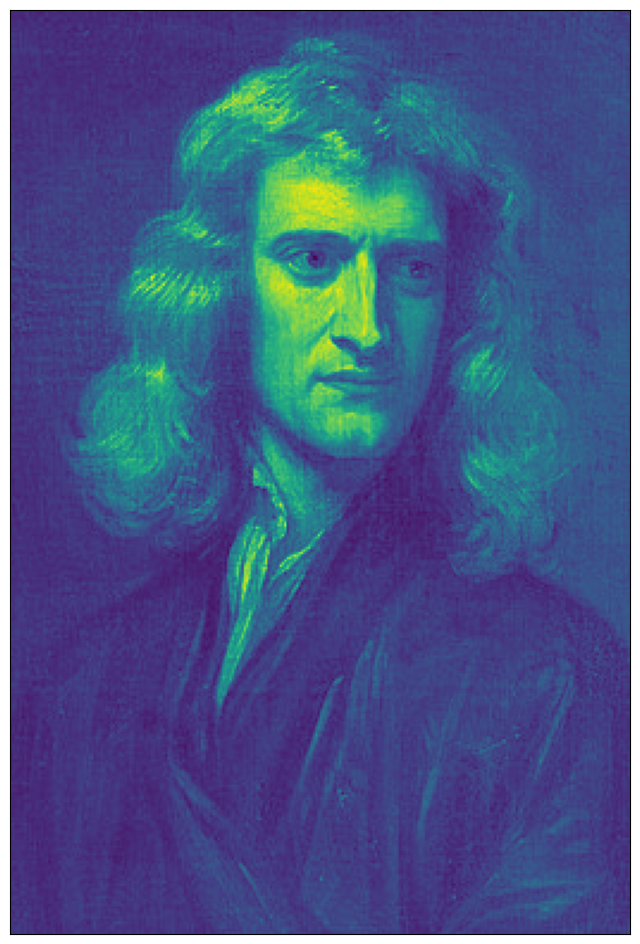

In [16]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import image
import numpy
from tqdm import tqdm
from utils import * 


rgb = image.imread("newton.jpg")
lines, columns = rgb.shape[:-1]

def rgb2gray(rgb):
    return numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))

fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.imshow(grey, aspect = 'auto')

#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 500000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1),((1-(categorical_samples//columns + torch.rand(num_samples))/lines)).unsqueeze(-1)], dim = -1)

logit_transform = logit(alpha = 1e-2)
transformed_samples = logit_transform.transform(target_samples)

mean = torch.mean(transformed_samples, dim = 0)
cov = torch.cov(transformed_samples.T)
instrumental = torch.distributions.MultivariateNormal(mean, (cov + cov.T)/2)
proposed_samples = instrumental.sample([num_samples])

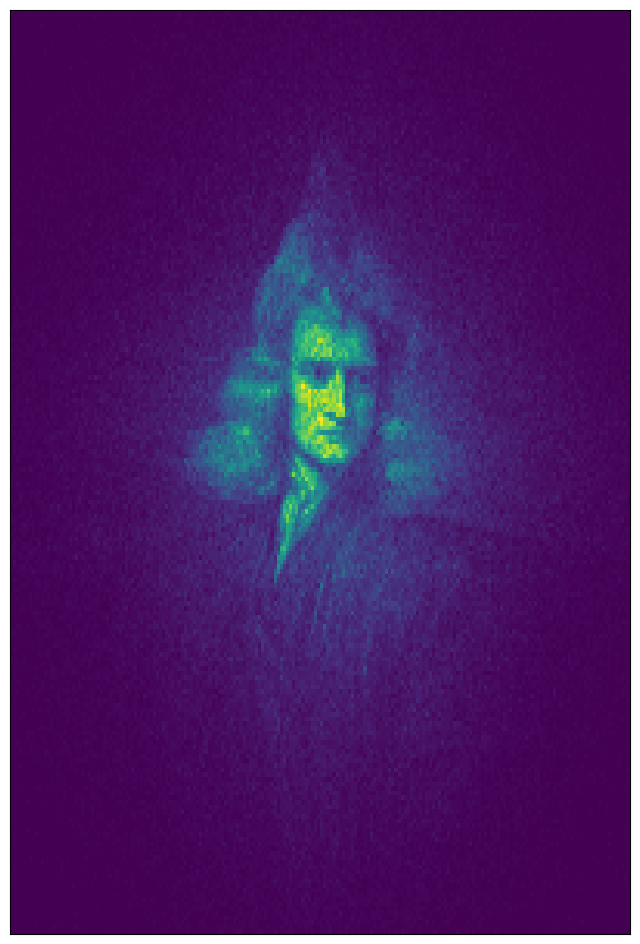

In [3]:
fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plot_image_2d_points(transformed_samples)

In [4]:
from classifiers import * 
binary_classif = BinaryClassifier(proposed_samples, transformed_samples,[512,512,512])
binary_classif.train(200,10000,lr = 1e-3, weight_decay = 0, verbose = True)
binary_classif.train(200,10000,lr = 5e-4, weight_decay = 5e-6, verbose = True)
binary_classif.train(200,10000,lr = 1e-4, weight_decay = 5e-6, verbose = True)
torch.save(binary_classif, 'model5.sav')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:41:04<00:00, 30.32s/it, loss = 33.298904; device = cuda]


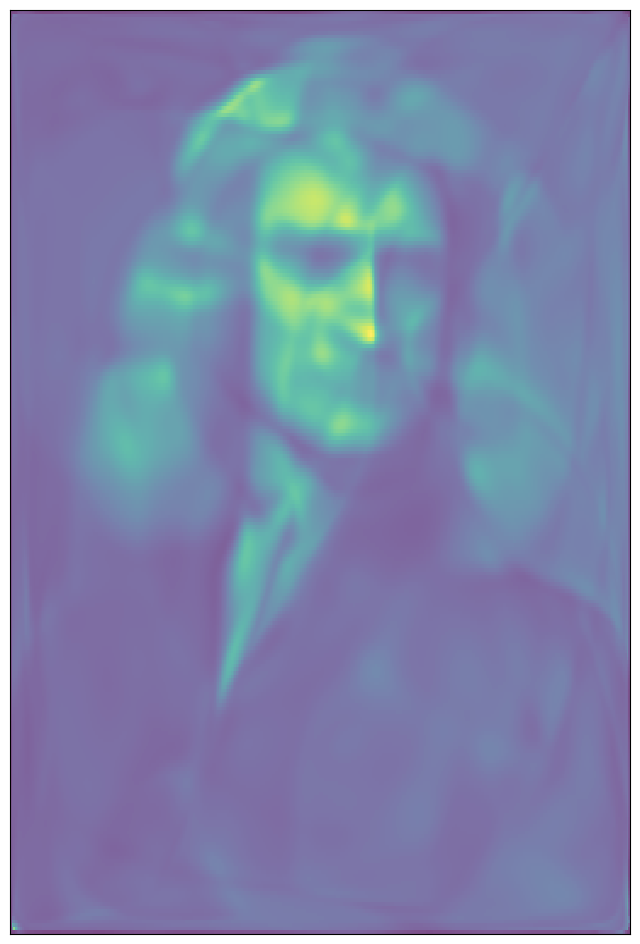

In [10]:
fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False) 
plot_2d_function(lambda x: torch.exp(binary_classif.logit_r(logit_transform.transform(x)).squeeze(-1) + instrumental.log_prob(logit_transform.transform(x)) + logit_transform.log_det(x)), bins = (lines, columns), range =([[0.,1.],[0.,1.]]))

In [11]:
proposed_samples = instrumental.sample([num_samples])
unormalized_weights = torch.exp(binary_classif.logit_r(proposed_samples)).squeeze(-1)
normalized_weights = unormalized_weights/torch.sum(unormalized_weights)
cat = torch.distributions.Categorical(normalized_weights).sample([num_samples])
samples = proposed_samples[cat]
inverse_samples = logit_transform.inverse_transform(samples)

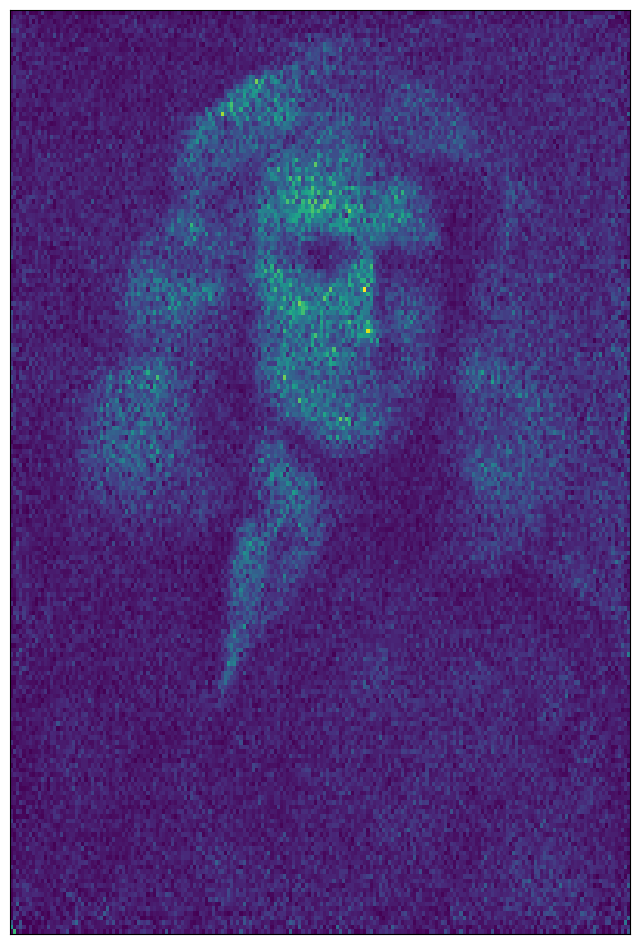

In [12]:
fig = plt.figure(figsize =(8,12))
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False) 
plot_image_2d_points(inverse_samples)